In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import zipfile
from tqdm import tqdm
import pytz

# Display all rows
pd.set_option('display.max_rows', None)

# ======== Load real-time data ========
df = pd.read_csv("/Users/kmcho/anaconda_projects/GTFS/converted_gtfs.csv", parse_dates=["vehicle_timestamp"])

utc = pytz.utc
eastern = pytz.timezone("America/New_York")
df["vehicle_timestamp"] = df["vehicle_timestamp"].dt.tz_localize(utc)
df["vehicle_timestamp_est"] = df["vehicle_timestamp"].dt.tz_convert(eastern)

c2_trips = df[df["vehicle_trip_routeId"] == "C2"].copy()

# ======== Function to load static GTFS data ========
def load_gtfs_file(zip_path, file_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_name) as f:
            return pd.read_csv(f)

# ======== Load static GTFS files ========
static_gtfs_path = '/Users/kmcho/anaconda_projects/GTFS/bus-gtfs-static.zip'
stops_df = load_gtfs_file(static_gtfs_path, 'stops.txt')
stop_times_df = load_gtfs_file(static_gtfs_path, 'stop_times.txt')
trips_df = load_gtfs_file(static_gtfs_path, 'trips.txt')

# ======== Handle duplicate entries ========
trip_ids = c2_trips["vehicle_trip_tripId"].unique()
conflict_summary = []

for trip_id in tqdm(trip_ids):
    trip_df = c2_trips[c2_trips["vehicle_trip_tripId"] == trip_id].copy()
    trip_df_clean = trip_df.drop(columns=["header_timestamp"], errors='ignore')
    dup = trip_df_clean[trip_df_clean.duplicated(subset=["vehicle_timestamp"], keep=False)]
    check = dup.groupby("vehicle_timestamp").agg(lambda x: x.dropna().nunique())
    is_different = check > 1
    conflict_timestamps = is_different.any(axis=1)
    different = check[conflict_timestamps]
    if not different.empty:
        for ts in different.index:
            differing_cols = is_different.loc[ts][is_different.loc[ts]].index.tolist()
            unique_values = check.loc[ts][differing_cols].to_dict()
            conflict_summary.append({
                "trip_id": trip_id,
                "vehicle_timestamp": ts,
                "num_conflicts": len(dup[dup["vehicle_timestamp"] == ts]),
                "conflicting_columns": differing_cols,
                "unique_values_by_column": unique_values
            })

conflict_df = pd.DataFrame(conflict_summary)
c2_trips_cleaned = c2_trips.drop(columns=["header_timestamp"], errors='ignore').drop_duplicates()

# ======== Attach direction_id ========
direction_lookup = trips_df[["trip_id", "direction_id"]].drop_duplicates()
direction_lookup.rename(columns={"trip_id": "vehicle_trip_tripId"}, inplace=True)
c2_trips_cleaned = c2_trips_cleaned.merge(direction_lookup, on="vehicle_trip_tripId", how="left")

# ======== Create trip_info_df ========
trip_info_list = []
for trip_id, group in c2_trips_cleaned.groupby("vehicle_trip_tripId"):
    group_sorted = group.sort_values("vehicle_timestamp")
    if group_sorted["vehicle_stopId"].notna().sum() >= 2:
        start_stop = group_sorted["vehicle_stopId"].iloc[0]
        end_stop = group_sorted["vehicle_stopId"].iloc[-1]
        direction_id = group_sorted["direction_id"].iloc[0]
        start_time = group_sorted["vehicle_timestamp"].min().tz_convert("America/New_York")
        end_time = group_sorted["vehicle_timestamp"].max().tz_convert("America/New_York")
        duration_min = (end_time - start_time).total_seconds() / 60
        trip_info_list.append({
            "trip_id": trip_id,
            "start_stop_id": start_stop,
            "end_stop_id": end_stop,
            "direction_id": direction_id,
            "start_time_est": start_time,
            "end_time_est": end_time,
            "duration_min": duration_min
        })

trip_info_df = pd.DataFrame(trip_info_list)

# ======== Add stop_name ========
stop_id_to_name = stops_df.set_index("stop_id")["stop_name"].to_dict()
trip_info_df["start_stop_name"] = trip_info_df["start_stop_id"].map(stop_id_to_name)
trip_info_df["end_stop_name"] = trip_info_df["end_stop_id"].map(stop_id_to_name)

# ======== Add combo_key ========
trip_info_df["combo_key"] = list(zip(
    trip_info_df["start_stop_id"],
    trip_info_df["end_stop_id"],
    trip_info_df["direction_id"]
))

# ======== Define grouped (추가된 핵심 부분) ========
grouped = trip_info_df.groupby(["start_stop_id", "end_stop_id", "direction_id"]).agg(
    num_trips=("trip_id", "count")
).reset_index()

# ======== Group timing information ========
combo_time_info = []
for _, row in grouped.iterrows():
    s, e, d = row["start_stop_id"], row["end_stop_id"], row["direction_id"]
    subset = trip_info_df[
        (trip_info_df["start_stop_id"] == s) &
        (trip_info_df["end_stop_id"] == e) &
        (trip_info_df["direction_id"] == d)
    ]
    combo_time_info.append({
        "start_stop_id": s,
        "end_stop_id": e,
        "direction_id": d,
        "num_trips": len(subset),
        "first_departure_time (EST)": subset["start_time_est"].min(),
        "last_arrival_time (EST)": subset["end_time_est"].max()
    })

combo_time_df = pd.DataFrame(combo_time_info)

# ======== Add combo_name and map ========
combo_time_df = combo_time_df.sort_values("first_departure_time (EST)").reset_index(drop=True)
combo_time_df["combo_name"] = ["Combo {:02d}".format(i + 1) for i in range(len(combo_time_df))]
combo_time_df["combo_key"] = list(zip(
    combo_time_df["start_stop_id"],
    combo_time_df["end_stop_id"],
    combo_time_df["direction_id"]
))

combo_info_map = combo_time_df.set_index("combo_key")[["combo_name", "num_trips"]].to_dict("index")

# ======== Calculate trip order within each combo ========
grouped_order = {}
for combo, group in trip_info_df.groupby("combo_key"):
    ordered = group.sort_values("start_time_est")
    grouped_order[combo] = {trip_id: i+1 for i, trip_id in enumerate(ordered["trip_id"])}

# ======== Generate combo_description column ========
def generate_combo_description(row):
    info = combo_info_map.get(row["combo_key"])
    order = grouped_order.get(row["combo_key"], {}).get(row["trip_id"], None)
    if info and order:
        return f"{info['combo_name']}: Trip {order} of {info['num_trips']}"
    return "Unknown combo"

trip_info_df["combo_description"] = trip_info_df.apply(generate_combo_description, axis=1)

# Sort and reorder columns
trip_info_df2 = trip_info_df[[
    "trip_id", "start_stop_id", "end_stop_id",
    "start_stop_name", "end_stop_name", "direction_id",
    "start_time_est", "end_time_est", "duration_min", "combo_description"
]].sort_values("start_time_est")

trip_info_df2

100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 26.16it/s]


,trip_id,start_stop_id,end_stop_id,start_stop_name,end_stop_name,direction_id,start_time_est,end_time_est,duration_min,combo_description
51,34380070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 05:43:36-04:00,2024-06-01 06:58:07-04:00,74.516667,Combo 01: Trip 1 of 29
13,10091070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:35:17-04:00,2024-06-01 08:21:56-04:00,106.650000,Combo 02: Trip 1 of 22
31,20725070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:35:24-04:00,2024-06-01 07:37:15-04:00,61.850000,Combo 02: Trip 2 of 22
67,47269070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 06:40:11-04:00,2024-06-01 07:53:25-04:00,73.233333,Combo 01: Trip 2 of 29
22,15502070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:58:29-04:00,2024-06-01 07:58:39-04:00,60.166667,Combo 02: Trip 3 of 22
25,17121070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 07:07:17-04:00,2024-06-01 08:30:03-04:00,82.766667,Combo 01: Trip 3 of 29
43,28287070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 07:37:45-04:00,2024-06-01 08:53:51-04:00,76.100000,Combo 01: Trip 4 of 29
14,10369070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 07:53:54-04:00,2024-06-01 08:48:23-04:00,54.483333,Combo 02: Trip 4 of 22
21,15104070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 08:02:58-04:00,2024-06-01 09:24:25-04:00,81.450000,Combo 01: Trip 5 of 29
47,31865070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 08:12:25-04:00,2024-06-01 10:03:51-04:00,111.433333,Combo 02: Trip 5 of 22


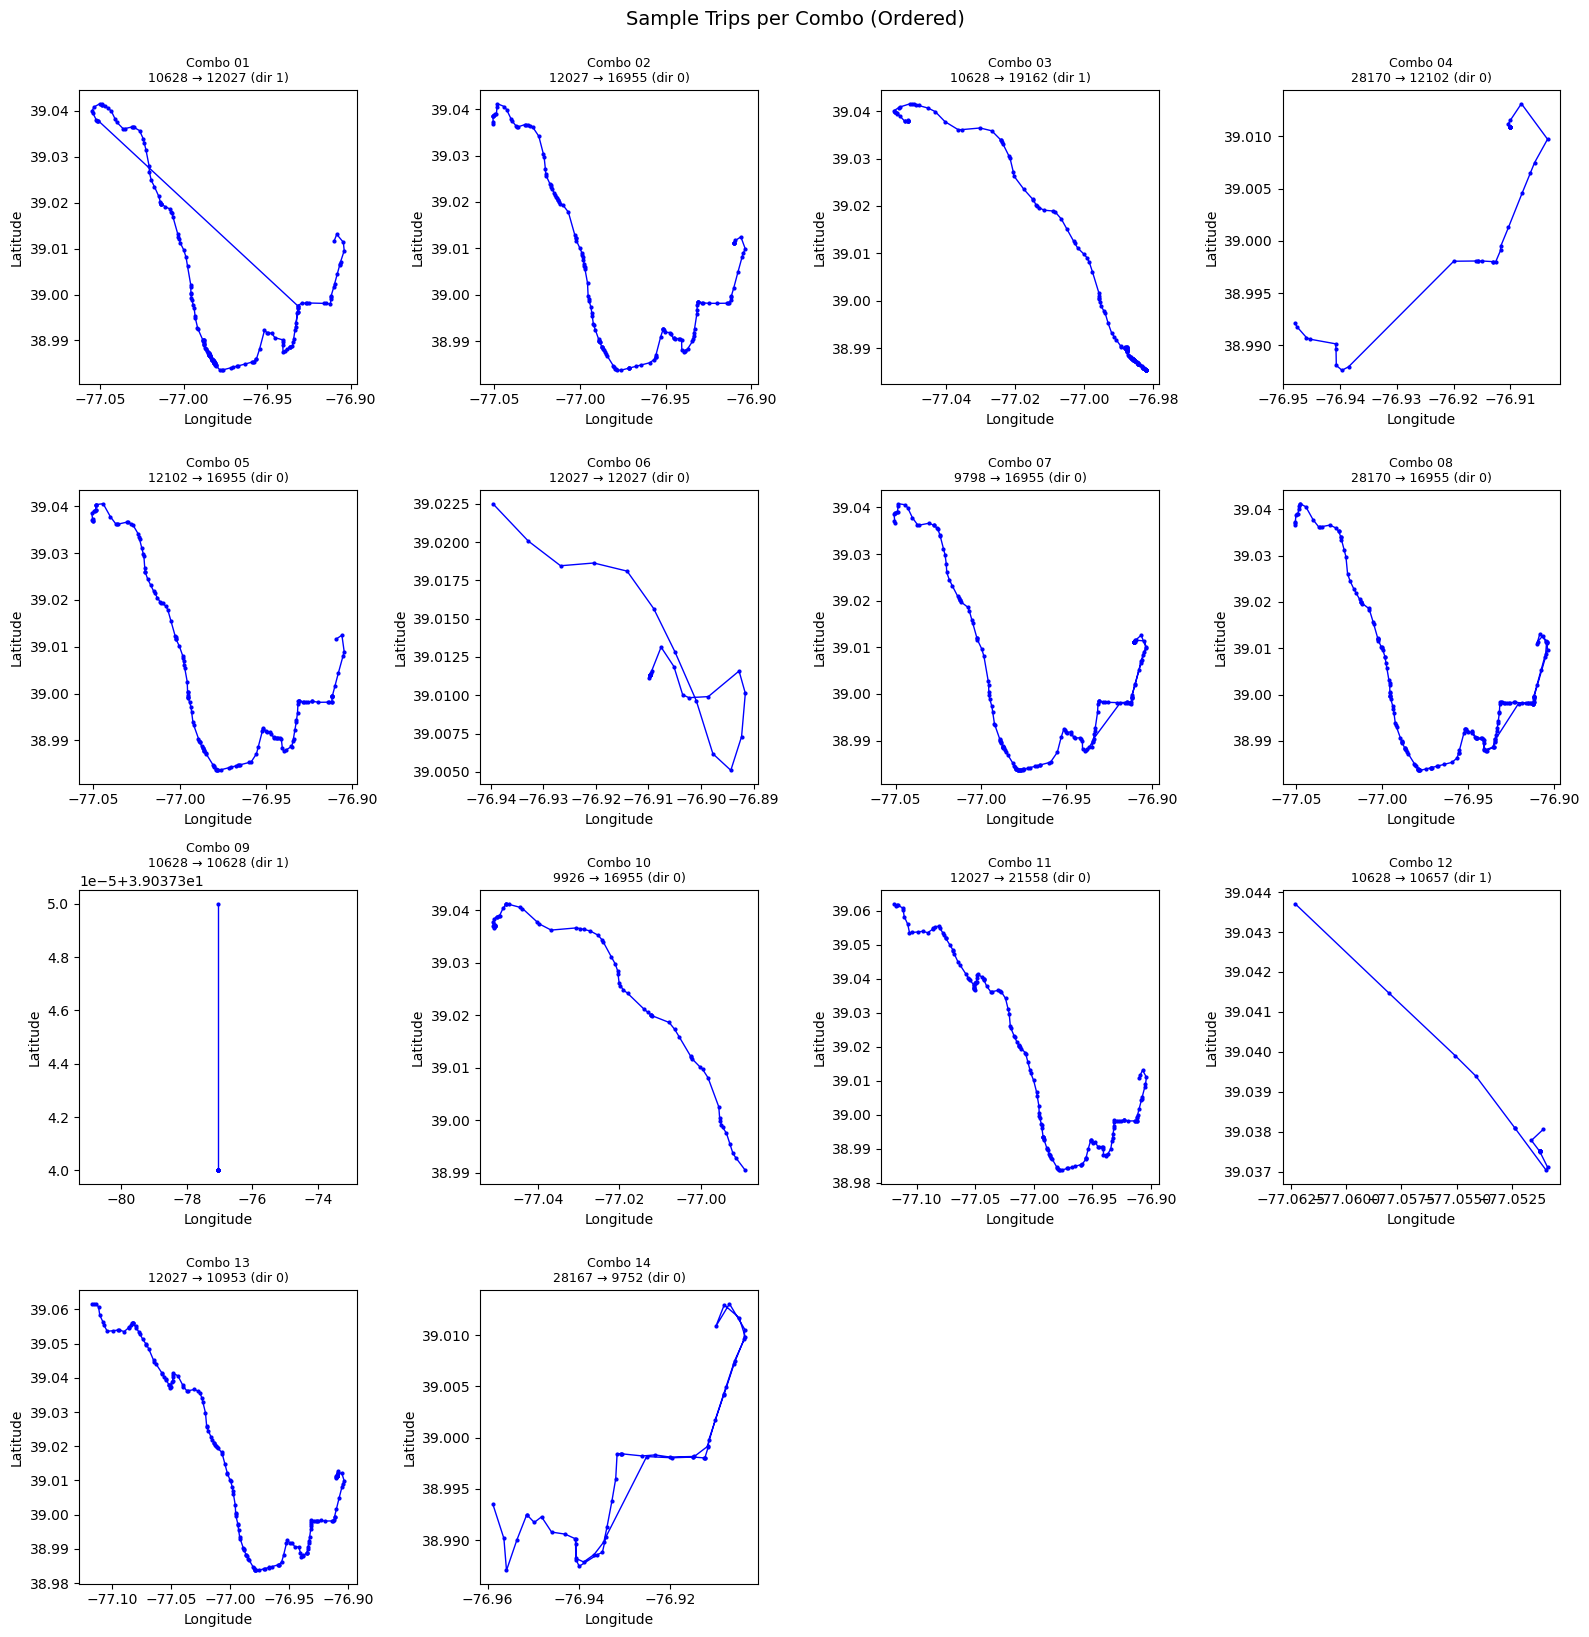

In [2]:
import matplotlib.pyplot as plt
import math

# Create combo_key
combo_time_df["combo_key"] = list(zip(
    combo_time_df["start_stop_id"],
    combo_time_df["end_stop_id"],
    combo_time_df["direction_id"]
))
trip_info_df["combo_key"] = list(zip(
    trip_info_df["start_stop_id"],
    trip_info_df["end_stop_id"],
    trip_info_df["direction_id"]
))

# Dictionary for mapping combo_key to combo_name
combo_name_map = combo_time_df.set_index("combo_key")["combo_name"].to_dict()

# Create a list of combo_keys in combo_name order
combo_keys_in_order = combo_time_df["combo_key"].tolist()

# Select one representative trip for each combo_key
representative_trips = []
for combo_key in combo_keys_in_order:
    trip_row = trip_info_df[trip_info_df["combo_key"] == combo_key].iloc[0]
    representative_trips.append(trip_row)

# Set subplot size
num_plots = len(representative_trips)
cols = 4
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for idx, row in enumerate(representative_trips):
    ax = axes[idx]
    trip_id = row["trip_id"]
    trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == trip_id].copy()

    if len(trip_df) < 5:
        ax.set_title("Too short")
        ax.axis("off")
        continue

    trip_df = trip_df.sort_values("vehicle_timestamp")
    lon = trip_df["vehicle_position_longitude"]
    lat = trip_df["vehicle_position_latitude"]

    combo_name = combo_name_map.get(row["combo_key"], "Unknown")
    ax.plot(lon, lat, marker='o', markersize=2, linewidth=1, color='blue')
    ax.set_title(f"{combo_name}\n{row['start_stop_id']} → {row['end_stop_id']} (dir {row['direction_id']})", fontsize=9)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Hide empty subplots
for i in range(num_plots, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Sample Trips per Combo (Ordered)", fontsize=14, y=1.02)
plt.show()


In [3]:
import folium

# ===== Initialize the map =====
# Set the map center based on the start stop of the first combo
first_start_stop = trip_info_df.iloc[0]["start_stop_id"]
first_lat = stops_df.loc[stops_df["stop_id"] == first_start_stop, "stop_lat"].values[0]
first_lon = stops_df.loc[stops_df["stop_id"] == first_start_stop, "stop_lon"].values[0]
m = folium.Map(location=[first_lat, first_lon], zoom_start=12)

# ===== Mark all start and end stops =====
for _, row in trip_info_df.iterrows():
    start_id = row["start_stop_id"]
    end_id = row["end_stop_id"]
    
    start_info = stops_df[stops_df["stop_id"] == start_id].iloc[0]
    end_info = stops_df[stops_df["stop_id"] == end_id].iloc[0]

    folium.Marker(
        location=[start_info["stop_lat"], start_info["stop_lon"]],
        icon=folium.Icon(color="green"),
        popup=f"Start: {start_info['stop_name']} ({start_id})"
    ).add_to(m)

    folium.Marker(
        location=[end_info["stop_lat"], end_info["stop_lon"]],
        icon=folium.Icon(color="red"),
        popup=f"End: {end_info['stop_name']} ({end_id})"
    ).add_to(m)

# ===== Add a polyline for a specific combo (e.g., combo_idx = 4 → Combo 05) =====
combo_idx = 1-1  # 예: Combo 05 → 인덱스는 0부터 시작

combo_row = combo_time_df.iloc[combo_idx]
start = combo_row["start_stop_id"]
end = combo_row["end_stop_id"]
direction = combo_row["direction_id"]

# Select a representative trip_id
target_trip = trip_info_df[
    (trip_info_df["start_stop_id"] == start) &
    (trip_info_df["end_stop_id"] == end) &
    (trip_info_df["direction_id"] == direction)
].sort_values("start_time_est").iloc[0]["trip_id"]

# Get the trip path
trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == target_trip].sort_values("vehicle_timestamp")
coords = list(zip(trip_df["vehicle_position_latitude"], trip_df["vehicle_position_longitude"]))

# Add the polyline
folium.PolyLine(locations=coords, color="blue", weight=5, opacity=0.7, tooltip=f"Combo {combo_idx+1:02d}").add_to(m)

# ===== Add stop points: stops that the selected trip passes through =====
trip_schedule = stop_times_df[stop_times_df["trip_id"] == target_trip].copy()
trip_schedule = trip_schedule.merge(
    stops_df[["stop_id", "stop_name", "stop_lat", "stop_lon"]],
    on="stop_id", how="left"
)

for _, stop in trip_schedule.iterrows():
    folium.CircleMarker(
        location=[stop["stop_lat"], stop["stop_lon"]],
        radius=4,
        color="blue",
        fill=True,
        fill_opacity=0.6,
        popup=f"{stop['stop_name']} ({stop['stop_id']})"
    ).add_to(m)


# Display the map
m


The blue line is a LineString connecting real-time GPS locations generated from `trip_df`, 
and the blue dots represent bus stop locations (`stop_lat`, `stop_lon`) from `stops_df`.